# Expansion Strategy in Mumbai City for Beriyan Biryani
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Biryani is one of the most consumed foods in India. It is estimated that the biryani market in India is estimated to be approximately Rs 1,500 crore (USD200M) in the organised sector, and Rs 15,000 crore (USD2B) in the unorganised sector.

**Beriyan Biryani**, a Biryani restaurant chain started out of Hyderabad, India has quickly garnered popularity and revenue growth. As they look to scale up, it sees Mumbai as the logical next choice of the city to expand to. Beriyan Biryani stakeholders are looking to choose a few localities in Mumbai to do a street level analysis, in order to come up with the prospecting address in Mumbai.

This project attempts to find optimal locations for restaurants in a city. Specifically, this report will be targeted to Beriyan Biryani stakeholders interested in opening an **Biryani restaurant** in **Mumbai**, India.

We will use data visualization and machine learning methods to generate a few most promissing neighborhoods based on this criteria. Each selection will be comprehensively outlined for the aforementioned stakeholders to make the choice

## Data <a name="data"></a>

Based on definition of our problem, some key factors that will influence the decision are:
* Density of Restaurants in a neighborhood
* Restaurant Ratings in a neighborhood
* Commercial Space Rates in a neighborhood

A map encapsulating all the major neighborhoods would be a good starting point.

Also, pertinent information about the neighborhoods would be necessary

Following data sources will be needed to extract/generate the required information:
* Mumbai neigborhoods will be availed by web-scraping the **Mumbai Wikipedia** page
* Neighborhood co-ordinates (Latitude and Longitude) will be retrieved using **Nominatim** module from **GeoPy** library
* Neighborhood data related to restaurants, venues etc. will be retrieved using **Foursquare API**
* Commercial Space Rates will be availed by web-scraping **MagicBricks** and **99Acres** (major online real estate platforms in India) database

### Mumbai Neighborhoods Dataframe

Mumbai Wikipedia page (https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai) lists all of the major neighborhoods in Mumbai, sorted by the suburbs, namely- Western, Eastern, Harbor and South Mumbai.

We have a basic csv file prepared made by copying this data. We start by importing it, along with the necessary libraries for data analysis and visualization.

In [1]:
# Importing Necessary Libraries
import numpy as np
import pandas as pd
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium 
from sklearn.cluster import KMeans

In [2]:
# Create Mumbai Neighborhoods dataframe from csv data
mum = pd.read_csv("Mumbai_Neighborhoods.csv")
mum.head()

,Suburb,Neighborhood,Commercial Rates
0,Western,Andheri,18639
1,Western,Mira Bhayandar,8369
2,Western,Bandra,33466
3,Western,Borivali,17238
4,Western,Dahisar,13064


In [3]:
# Get co-ordinates for each neighborhood and add them to the neighborhoods dataframe
geolocator = Nominatim(user_agent="foursquare_agent")
latitude = []
longitude = []
for i in mum['Neighborhood']:
    location = geolocator.geocode(i+',Mumbai')
    try:                                            # Co-ordinates for some neighborhoods may not be available, we replace
        latitude.append(location.latitude)          # those with NaN
        longitude.append(location.longitude)
    except:
        latitude.append(np.nan)
        longitude.append(np.nan)
mum['Latitude'] = pd.Series(latitude)
mum['Longitude'] = pd.Series(longitude)
mum.head()

,Suburb,Neighborhood,Commercial Rates,Latitude,Longitude
0,Western,Andheri,18639,19.119698,72.846420
1,Western,Mira Bhayandar,8369,NaN,NaN
2,Western,Bandra,33466,19.054979,72.840220
3,Western,Borivali,17238,19.229068,72.857363
4,Western,Dahisar,13064,19.249450,72.859621


In [4]:
# Remove the neighborhoods with NaN co-ordinates
mum.dropna(inplace=True)
mum.reset_index(inplace=True)
mum.head()

,index,Suburb,Neighborhood,Commercial Rates,Latitude,Longitude
0,0,Western,Andheri,18639,19.119698,72.846420
1,2,Western,Bandra,33466,19.054979,72.840220
2,3,Western,Borivali,17238,19.229068,72.857363
3,4,Western,Dahisar,13064,19.249450,72.859621
4,5,Western,Goregaon,11121,19.164803,72.850045


In [5]:
del mum['index']
mum.head()

,Suburb,Neighborhood,Commercial Rates,Latitude,Longitude
0,Western,Andheri,18639,19.119698,72.846420
1,Western,Bandra,33466,19.054979,72.840220
2,Western,Borivali,17238,19.229068,72.857363
3,Western,Dahisar,13064,19.249450,72.859621
4,Western,Goregaon,11121,19.164803,72.850045


Now that the data is cleaned up and ready, let us create a map visualization of the Mumbai neighborhoods, so as to get the geographical overview of the city.

In [6]:
# Finding the latitude and longitude for Mumbai

address = 'Goregaon, Mumbai'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print("Mumbai co-ordinates are:",latitude, longitude)

Mumbai co-ordinates are: 19.1648029 72.8500454


In [7]:
# Creating Mumbai map and marking the neighborhoods from dataframe on it

map_mumbai = folium.Map(location=[latitude, longitude], zoom_start=10)


for lat, lng, neighborhood in zip(mum['Latitude'], mum['Longitude'], mum['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#A5AAFF ',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mumbai)  

map_mumbai


## Methodology <a name="methodology"></a>

### Data Mining
Foursquare is a social location service that allows users to explore the world around them.
The Foursquare API allows application developers to interact with the Foursquare platform.

We have Mumbai neighobrhoods ready, now we use **Foursquare API** to get info on venues in each Mumbai neighborhood. The venues are categorized in several types such as Indian Restaurants, Internet Cafes, Car Showrooms etc.

We will be gathering **location (co-ordinates), venue name and venue category** for each Mumbai neighborhood.

For the perview of this project, we will be considering venues relavant to food only, unrelated venue categories such as Convenience store, Gym, Library etc. will be removed. This will remove the noise and improve the quality of the clustering and of the insights gathered from it.

### Exploratory Analysis
We will visualize the **venue density and commercial space rates** in the neighborhoods. We will also take a look at what kind of venues are the most popular for a given neighborhood. This will help us understand the distribution of venue categories and even identify a trend in the data.

### Clustering

In this final step we will find **clusters of locations** based on the data and try to gain an understanding of those clusters from the stakeholders' perspective. We will present map of all such locations but also create clusters (using **k-means clustering**) of those locations to identify neighborhoods which should be a starting point for final 'street level' exploration and search for optimal venue location by stakeholders.

We start by setting up Client credentials for Foursquare API

In [8]:
CLIENT_ID = 'BEOXN0050X0Q2TAMAV1G4WG5AMT0ESFSM1O21CTY5OWTB00D'
CLIENT_SECRET = '5HWTCTKTJ0KR1W0T2GBC0EFWMGZTE3P1IQQ21XDLNMTKFT3R'
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BEOXN0050X0Q2TAMAV1G4WG5AMT0ESFSM1O21CTY5OWTB00D
CLIENT_SECRET:5HWTCTKTJ0KR1W0T2GBC0EFWMGZTE3P1IQQ21XDLNMTKFT3R


In [9]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=BEOXN0050X0Q2TAMAV1G4WG5AMT0ESFSM1O21CTY5OWTB00D&client_secret=5HWTCTKTJ0KR1W0T2GBC0EFWMGZTE3P1IQQ21XDLNMTKFT3R&v=20180604&ll=19.1648029,72.8500454&radius=500&limit=100'

Now we define a function that will return venues within specific radius of a neighborhood, from Foursquare API. This will help us populate the data on restaurant name, categories, location etc.

In [10]:
# Create a function to get the nearby venues to a neighborhood
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # URL to fetch data from Foursquare API
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
# Get the nearby venues for Mumbai neighborhoods
mum_venues = getNearbyVenues(names=mum['Neighborhood'],
                                   latitudes=mum['Latitude'],
                                   longitudes=mum['Longitude']
                                  )
mum_venues.head()

Andheri
Bandra
Borivali
Dahisar
Goregaon
Jogeshwari
Juhu
Kandivali West
Kandivali East
Khar
Malad
Santacruz
Vasai
Virar
Vile Parle
Bhandup
Ghatkopar
Kanjurmarg
Kurla
Mulund
Nahur
Powai
Vidyavihar
Vikhroli
Chembur
Govandi
Mankhurd
Trombay
Antop Hill
Byculla
Colaba
Dadar
Fort
Girgaon
Kalbadevi
Kamathipura
Matunga
Parel
Tardeo
Churchgate
Lower Parel
Mahim
Sion
Worli
Malabar Hill


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Andheri,19.119698,72.84642,Merwans Cake shop,19.119300,72.845418,Bakery
1,Andheri,19.119698,72.84642,Narayan Sandwich,19.121398,72.850270,Sandwich Place
2,Andheri,19.119698,72.84642,McDonald's,19.119691,72.846102,Fast Food Restaurant
3,Andheri,19.119698,72.84642,Cafe Alfa,19.119667,72.843560,Indian Restaurant
4,Andheri,19.119698,72.84642,McDonald's,19.118411,72.848002,Fast Food Restaurant


In [12]:
print('There are {} venues.'.format(mum_venues.shape))
print('There are {} uniques venue categories.'.format(len(mum_venues['Venue Category'].unique())))
mum_venues['Venue Category'].unique()

There are (750, 7) venues.
There are 150 uniques venue categories.


array(['Bakery', 'Sandwich Place', 'Fast Food Restaurant',
       'Indian Restaurant', 'Restaurant', 'Food Court', 'Pizza Place',
       'Platform', 'Café', 'Convenience Store', 'Train Station',
       'Design Studio', 'Italian Restaurant', 'Brewery', 'Pier', 'Pub',
       'Furniture / Home Store', 'Food Truck', 'Ice Cream Shop',
       'Chinese Restaurant', 'Department Store', 'Clothing Store',
       'Burger Joint', 'Snack Place', 'Mobile Phone Shop', 'Optical Shop',
       'Seafood Restaurant', 'Bookstore', 'Bar',
       'Vegetarian / Vegan Restaurant', 'Farm', 'Fish Market',
       'Mughlai Restaurant', 'Asian Restaurant', 'Theater', 'Lounge',
       'Cocktail Bar', 'Hotel', 'Donut Shop', 'Smoke Shop',
       'American Restaurant', 'Gym / Fitness Center', 'Spa', 'Beach',
       'Coffee Shop', 'Hotel Bar', 'Track', 'Hookah Bar', 'Food',
       'Dessert Shop', 'Bank', 'Sports Bar', 'Neighborhood',
       'Fried Chicken Joint', 'Park', 'Food & Drink Shop', 'Pharmacy',
       'Juice Ba

As we can see, a total of 150 venue categories are retrieved. Now, as discussed in the Methodology section, for the perview of this project, we will be considering venues relavant to food only.

In [13]:
mum_food_venues = mum_venues[mum_venues['Venue Category'].isin(['Bakery', 'Sandwich Place', 'Fast Food Restaurant',
       'Indian Restaurant', 'Restaurant', 'Food Court', 'Pizza Place',
       'Café',
        'Italian Restaurant', 'Brewery', 'Pub',
        'Food Truck', 'Ice Cream Shop',
       'Chinese Restaurant',
       'Burger Joint', 'Snack Place',
       'Seafood Restaurant', 'Bar',
       'Vegetarian / Vegan Restaurant', 'Fish Market',
       'Mughlai Restaurant', 'Asian Restaurant', 
       'Cocktail Bar', 'Hotel', 'Donut Shop', 'Smoke Shop',
       'American Restaurant',
       'Coffee Shop', 'Hotel Bar', 'Hookah Bar', 'Food',
       'Dessert Shop', 'Sports Bar',
       'Fried Chicken Joint', 'Food & Drink Shop',
       'Juice Bar', 'Beer Bar', 'Nightclub',
       'Beer Garden', 'Gastropub', 'Bengali Restaurant',
       'Steakhouse', 'Diner',
       'Bistro', 'Whisky Bar', 'Mediterranean Restaurant', 
       'Maharashtrian Restaurant', 'Tea Room',
       'Cupcake Shop', 'Falafel Restaurant', 'Moroccan Restaurant',
       'North Indian Restaurant',
       'Bed & Breakfast', 'Creperie', 
       'Tex-Mex Restaurant', 'Dhaba', 'Hot Dog Joint',
       'Middle Eastern Restaurant', 'Breakfast Spot',
       'Thai Restaurant',
       'Irani Cafe',
       'Parsi Restaurant', 'BBQ Joint',
       'Multicuisine Indian Restaurant',
       'South Indian Restaurant',
       'Soup Place',
       'Japanese Restaurant'])].reset_index(drop=True)

mum_food_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Andheri,19.119698,72.84642,Merwans Cake shop,19.119300,72.845418,Bakery
1,Andheri,19.119698,72.84642,Narayan Sandwich,19.121398,72.850270,Sandwich Place
2,Andheri,19.119698,72.84642,McDonald's,19.119691,72.846102,Fast Food Restaurant
3,Andheri,19.119698,72.84642,Cafe Alfa,19.119667,72.843560,Indian Restaurant
4,Andheri,19.119698,72.84642,McDonald's,19.118411,72.848002,Fast Food Restaurant


In [14]:
print('There are {} uniques venue categories of food places.'.format(len(mum_food_venues['Venue Category'].unique())))
mum_food_venues['Venue Category'].unique()

There are 67 uniques venue categories of food places.


array(['Bakery', 'Sandwich Place', 'Fast Food Restaurant',
       'Indian Restaurant', 'Restaurant', 'Food Court', 'Pizza Place',
       'Café', 'Italian Restaurant', 'Brewery', 'Pub', 'Food Truck',
       'Ice Cream Shop', 'Chinese Restaurant', 'Burger Joint',
       'Snack Place', 'Seafood Restaurant', 'Bar',
       'Vegetarian / Vegan Restaurant', 'Fish Market',
       'Mughlai Restaurant', 'Asian Restaurant', 'Cocktail Bar', 'Hotel',
       'Donut Shop', 'Smoke Shop', 'American Restaurant', 'Coffee Shop',
       'Hotel Bar', 'Hookah Bar', 'Food', 'Dessert Shop', 'Sports Bar',
       'Fried Chicken Joint', 'Food & Drink Shop', 'Juice Bar',
       'Beer Bar', 'Nightclub', 'Beer Garden', 'Gastropub',
       'Bengali Restaurant', 'Steakhouse', 'Diner', 'Bistro',
       'Whisky Bar', 'Mediterranean Restaurant',
       'Maharashtrian Restaurant', 'Tea Room', 'Cupcake Shop',
       'Falafel Restaurant', 'Moroccan Restaurant',
       'North Indian Restaurant', 'Bed & Breakfast', 'Creperie'

In [15]:
mum_bai = pd.merge(mum, mum_food_venues, on="Neighborhood")
mum_bai.drop(['Neighborhood Latitude', 'Neighborhood Longitude'], axis=1, inplace=True)
mum_bai.head()

,Suburb,Neighborhood,Commercial Rates,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Western,Andheri,18639,19.119698,72.84642,Merwans Cake shop,19.119300,72.845418,Bakery
1,Western,Andheri,18639,19.119698,72.84642,Narayan Sandwich,19.121398,72.850270,Sandwich Place
2,Western,Andheri,18639,19.119698,72.84642,McDonald's,19.119691,72.846102,Fast Food Restaurant
3,Western,Andheri,18639,19.119698,72.84642,Cafe Alfa,19.119667,72.843560,Indian Restaurant
4,Western,Andheri,18639,19.119698,72.84642,McDonald's,19.118411,72.848002,Fast Food Restaurant


Now we have the venue data that we can use to cluster the neighborhoods and analyze. We have gathered the venues from Foursquare API for Mumbai neighborhoods and filtered by the categories relevant to our analysis, i.e. the Food category.

Let's take a view at which neighborhoods have greater density of food places, we will visualize it using a bubble map.

In [16]:
# Creating Mumbai map and marking the neighborhoods with bubbles sized according to no of food places in them
test = mum_bai.sort_values('Neighborhood')
# Getting number of food places and normalizing from 0 to 10
venues_count = test.groupby('Neighborhood')['Venue'].count()
venues_count = 1 + venues_count/venues_count.max() * 9

map_mumbai_food = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, neighborhood, venue_size in zip(test['Latitude'].unique(), test['Longitude'].unique(), test['Neighborhood'].unique(), venues_count):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=venue_size**1.5,
        popup=label,
        color=False,
        fill=True,
        fill_color='#A0F369',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mumbai_food)  

map_mumbai_food


As we can see, prominent residential neighborhoods such as Powai, Colaba, Juhu, Khar, Santacruz etc. have higher density of food places. One key insight would be to avoid selecting such a locality that has higher density of food places.

It would also be a good idea to visualize the commercial property prices for neighborhoods, hence we map them by color scale.

In [17]:
# Creating Mumbai map and marking the neighborhoods with color scale according to commercial property rates

color_scale = pd.cut(mum_bai['Commercial Rates'], bins=4, 
                              labels=['green', 'yellow', 'orange', 'red'])

map_mumbai_comm = folium.Map(location=[latitude, longitude], zoom_start=10)


for lat, lng, neighborhood, marker_color in zip(mum_bai['Latitude'], mum_bai['Longitude'], mum_bai['Neighborhood'], color_scale):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color=False,
        fill=True,
        fill_color=marker_color,
        fill_opacity=0.2,
        parse_html=False).add_to(map_mumbai_comm)  

map_mumbai_comm


It's no surprise that South Mumbai neighborhoods fetch greatest price for the commercial property, they have greater business activity and higher level of quality of life. Also, South-Westerm neighborhoods are highly priced, owing to the well planned neighborhoods and more recreational venues.

## Analysis <a name="analysis"></a>

Now we will proceed with the analysis part. As discussed in the Methodology section, we will be doing **K-means clustering** on our dataframe, taking into consideration a variety of parameters such as Venue Categories, Commercial Rates, number of Venues etc.
The k-means clustering algorithm attempts to split a given anonymous data set (a set containing no information as to class identity) into a fixed number (k) of clusters. These clusters often exhbit a unique characteristic trend that we can identify with analysis of the clusters.

We start by setting up our data appropriately for the K-means clustering.

In [18]:
# Cetegorical encoding of the dataframe
mum_bai_onehot = pd.get_dummies(mum_bai[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
mum_bai_onehot['Neighborhood'] = mum_bai['Neighborhood'] 
mum_bai_onehot['Commercial Rates'] = mum_bai['Commercial Rates'] 

first_col = mum_bai_onehot.pop('Neighborhood')
second_col = mum_bai_onehot.pop('Commercial Rates')
mum_bai_onehot.insert(0, 'Neighborhood', first_col)
mum_bai_onehot.insert(1, 'Commercial Rates', second_col)

mum_bai_onehot.head()

,Neighborhood,Commercial Rates,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,...,Snack Place,Soup Place,South Indian Restaurant,Sports Bar,Steakhouse,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Whisky Bar
0,Andheri,18639,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Andheri,18639,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Andheri,18639,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Andheri,18639,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Andheri,18639,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
mum_bai_onehot.shape

(553, 69)

In [20]:
mum_bai_grouped = mum_bai_onehot.groupby('Neighborhood').mean().reset_index()
mum_bai_grouped.head()

,Neighborhood,Commercial Rates,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,...,Snack Place,Soup Place,South Indian Restaurant,Sports Bar,Steakhouse,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Whisky Bar
0,Andheri,18639,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Antop Hill,28571,0.0,0.0,0.0,0.000000,0.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Bandra,33466,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bhandup,14890,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Borivali,17238,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In order to further remove the noise, we will be considering only the top ten venue categories from a neighborhood. This will de-clutter the data further and clustering will be much more neat, which will help us identify the trends even further.

In [21]:
# Return top n venue categories in a neighborhood
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [22]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
mum_bai_top = pd.DataFrame(columns=columns)
mum_bai_top['Neighborhood'] = mum_bai_grouped['Neighborhood']

for ind in np.arange(mum_bai_grouped.shape[0]):
    mum_bai_top.iloc[ind, 1:] = return_most_common_venues(mum_bai_grouped.iloc[ind, :], num_top_venues)

mum_bai_top.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Andheri,Commercial Rates,Fast Food Restaurant,Indian Restaurant,Sandwich Place,Food Court,Bakery,Pizza Place,Restaurant,Creperie,Cupcake Shop
1,Antop Hill,Commercial Rates,Diner,Bar,Fast Food Restaurant,Cupcake Shop,Dessert Shop,Dhaba,Donut Shop,Falafel Restaurant,Fish Market
2,Bandra,Commercial Rates,Café,Indian Restaurant,Brewery,Pub,Restaurant,Italian Restaurant,Diner,Cupcake Shop,Dessert Shop
3,Bhandup,Commercial Rates,Falafel Restaurant,Hotel,Indian Restaurant,Cupcake Shop,Dessert Shop,Dhaba,Diner,Donut Shop,Fish Market
4,Borivali,Commercial Rates,Ice Cream Shop,Chinese Restaurant,Snack Place,Burger Joint,Pizza Place,Restaurant,Café,Food Truck,Bed & Breakfast


In [23]:
# Add Venue Count to the datafram, it may be an important metric for clustering
A = list(test.groupby('Neighborhood')['Venue'].count())
mum_bai_top.sort_values(by = 'Neighborhood', inplace=True)
mum_bai_top.insert(2, 'Venue Count', A)
mum_bai_top.head()

,Neighborhood,1st Most Common Venue,Venue Count,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Andheri,Commercial Rates,9,Fast Food Restaurant,Indian Restaurant,Sandwich Place,Food Court,Bakery,Pizza Place,Restaurant,Creperie,Cupcake Shop
1,Antop Hill,Commercial Rates,2,Diner,Bar,Fast Food Restaurant,Cupcake Shop,Dessert Shop,Dhaba,Donut Shop,Falafel Restaurant,Fish Market
2,Bandra,Commercial Rates,10,Café,Indian Restaurant,Brewery,Pub,Restaurant,Italian Restaurant,Diner,Cupcake Shop,Dessert Shop
3,Bhandup,Commercial Rates,3,Falafel Restaurant,Hotel,Indian Restaurant,Cupcake Shop,Dessert Shop,Dhaba,Diner,Donut Shop,Fish Market
4,Borivali,Commercial Rates,10,Ice Cream Shop,Chinese Restaurant,Snack Place,Burger Joint,Pizza Place,Restaurant,Café,Food Truck,Bed & Breakfast


Now, one important thing to consider is that the K-means algorithm (discussed further) splits data into as many clusters as we specify. After all, we could split the data into as many datapoints there are and that would be a perfect split! Alas, we need to find as few significant clusters as we can, in order to make sense of them.

Determining the optimal number of clusters in a data set is a fundamental issue in partitioning clustering, such as k-means clustering, which requires the user to specify the number of clusters k to be generated.

Unfortunately, there is no definitive answer to this question. The optimal number of clusters is somehow subjective and depends on the method used for measuring similarities and the parameters used for partitioning.

Some approches to determine number of clusters consist of optimizing a criterion, such as the within cluster sums of squares or the average silhouette. Most commonly used methods are elbow and silhouette methods.

We will be choosing optimum number of clusters by using **Elbow method**.

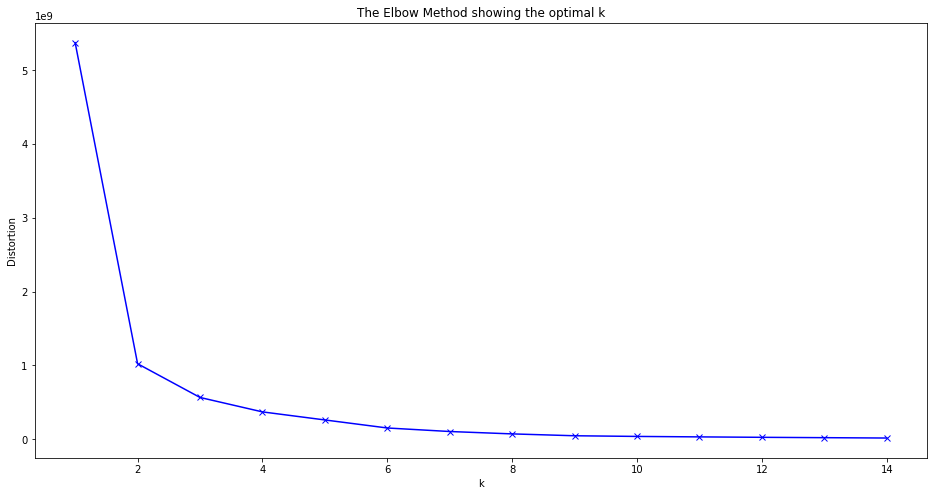

In [24]:
import matplotlib.pyplot as plt

mum_bai_cluster = mum_bai_grouped.drop('Neighborhood', 1)

distortions = []

K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(mum_bai_cluster)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The Elbow Method suggests 2 as the optimum number of clusters, as the distortion in the data drops suddenly at 2 clusters and very slowly decreases from there. But considering insights from the exploratory data analysis, we will proceed with grouping the data into **3 clusters**, as it will be easier to gather insights that way. 

In [25]:
kclusters = 3

mum_bai_cluster = mum_bai_grouped.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mum_bai_cluster)

In [26]:
mum_bai_top.insert(0, 'Cluster Labels', kmeans.labels_)

mum_bai_merged = mum_bai

mum_bai_merged = mum_bai_merged.join(mum_bai_top.set_index('Neighborhood'), on='Neighborhood')

mum_bai_merged.head()

,Suburb,Neighborhood,Commercial Rates,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,...,Venue Count,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Western,Andheri,18639,19.119698,72.84642,Merwans Cake shop,19.119300,72.845418,Bakery,0,...,9,Fast Food Restaurant,Indian Restaurant,Sandwich Place,Food Court,Bakery,Pizza Place,Restaurant,Creperie,Cupcake Shop
1,Western,Andheri,18639,19.119698,72.84642,Narayan Sandwich,19.121398,72.850270,Sandwich Place,0,...,9,Fast Food Restaurant,Indian Restaurant,Sandwich Place,Food Court,Bakery,Pizza Place,Restaurant,Creperie,Cupcake Shop
2,Western,Andheri,18639,19.119698,72.84642,McDonald's,19.119691,72.846102,Fast Food Restaurant,0,...,9,Fast Food Restaurant,Indian Restaurant,Sandwich Place,Food Court,Bakery,Pizza Place,Restaurant,Creperie,Cupcake Shop
3,Western,Andheri,18639,19.119698,72.84642,Cafe Alfa,19.119667,72.843560,Indian Restaurant,0,...,9,Fast Food Restaurant,Indian Restaurant,Sandwich Place,Food Court,Bakery,Pizza Place,Restaurant,Creperie,Cupcake Shop
4,Western,Andheri,18639,19.119698,72.84642,McDonald's,19.118411,72.848002,Fast Food Restaurant,0,...,9,Fast Food Restaurant,Indian Restaurant,Sandwich Place,Food Court,Bakery,Pizza Place,Restaurant,Creperie,Cupcake Shop


Now we have the entire datapoints grouped into three clusters, we can view the cluster label in the column 'Cluter Labels'. They take values in [0, 1, 2].

Now we map the neighborhoods by color coding them according to the cluster they belong in.

In [27]:
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lon, poi, cluster in zip(mum_bai_merged['Latitude'], mum_bai_merged['Longitude'], mum_bai_merged['Neighborhood'], mum_bai_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

From the first glance, it appears that high-commercial rate neighborhoods have been allocated to the cluster with purple markers and so on. But let's dive into the results of this clustering analysis and derive some insights from it.

## Results and Discussion <a name="results"></a>

We will analyze each cluster with regards to the two important metrics we have at hand: the type of restaurant in the neighborhood and the commercial rates in the neighborhood.

In [28]:
# Split the data into three, as per the clusters
mum_bai_one = mum_bai_merged[mum_bai_merged['Cluster Labels'] == 0]
mum_bai_two = mum_bai_merged[mum_bai_merged['Cluster Labels'] == 1]
mum_bai_three = mum_bai_merged[mum_bai_merged['Cluster Labels'] == 2]

In [29]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Now we create a distribution plot for venue categories in each cluster. This will give us insight into the kind of food places a cluster contains. 

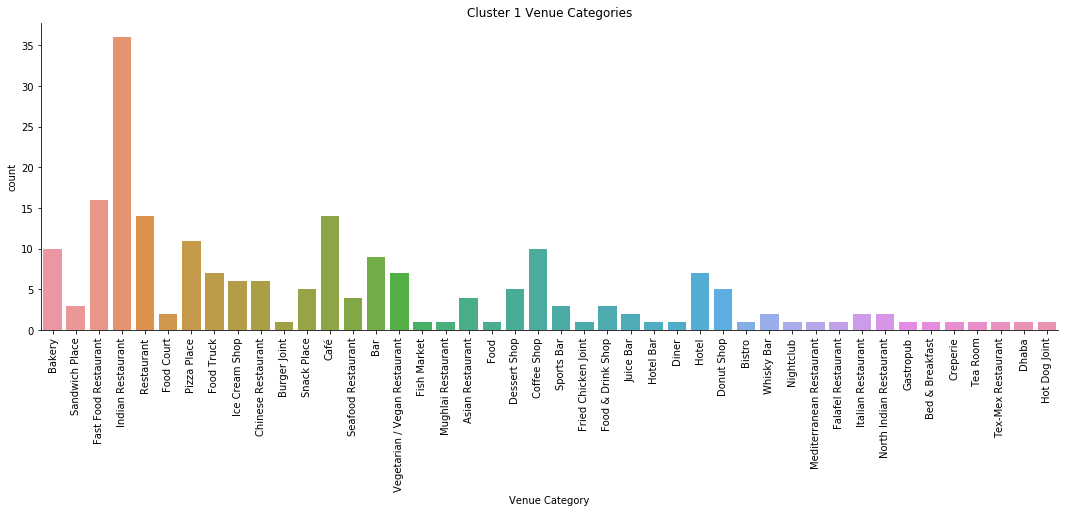

In [30]:
c1 = sns.catplot(x="Venue Category", kind="count", data=mum_bai_one, height=5, aspect=3)
c1.set_xticklabels(rotation=90, fontsize=10)
plt.title("Cluster 1 Venue Categories")
plt.show()

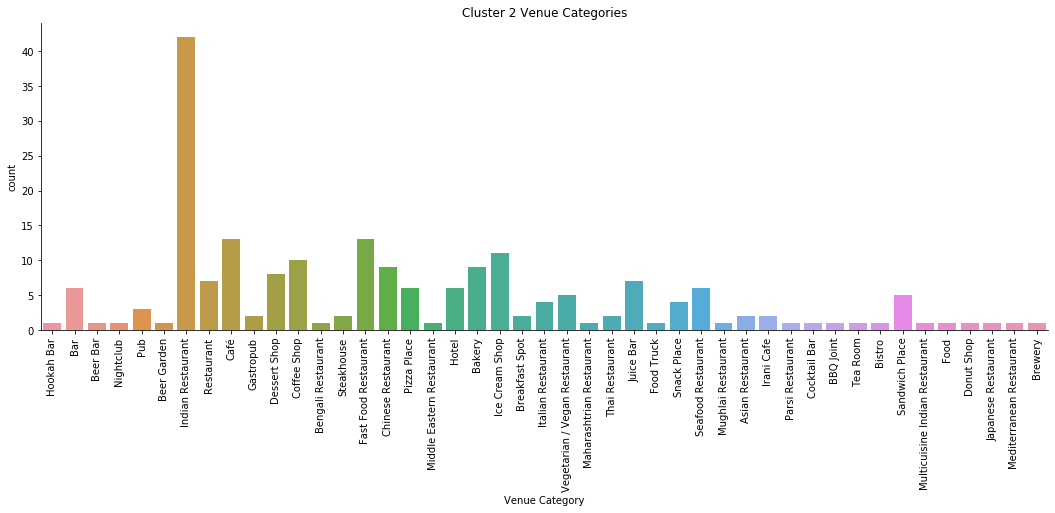

In [31]:
c2 = sns.catplot(x="Venue Category", kind="count", data=mum_bai_two, height=5, aspect=3)
c2.set_xticklabels(rotation=90, fontsize=10)
plt.title("Cluster 2 Venue Categories")
plt.show()

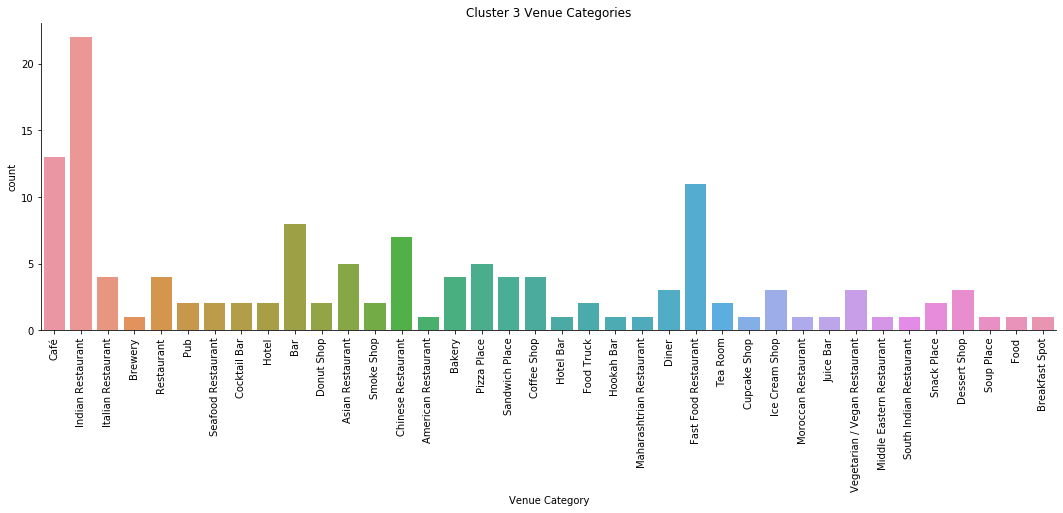

In [32]:
c3 = sns.catplot(x="Venue Category", kind="count", data=mum_bai_three, height=5, aspect=3)
c3.set_xticklabels(rotation=90, fontsize=10)
plt.title("Cluster 3 Venue Categories")
plt.show()

Looking at these charts, it is amply evident that Indian Restaurants, Fast Food Restaurants and Cafes are the three most popular food venues in all of the clusters. 
One notable observation is that although cluster 3 has fewer number of venues, it has relatively much more balanced distribution overall. This means that neighborhoods in cluster 3 contain a much broader variety of food places as compared to clusters 1 and 2.

Now we take a look at what kind of distribution we can find when we consider commercial rates of different clusters.

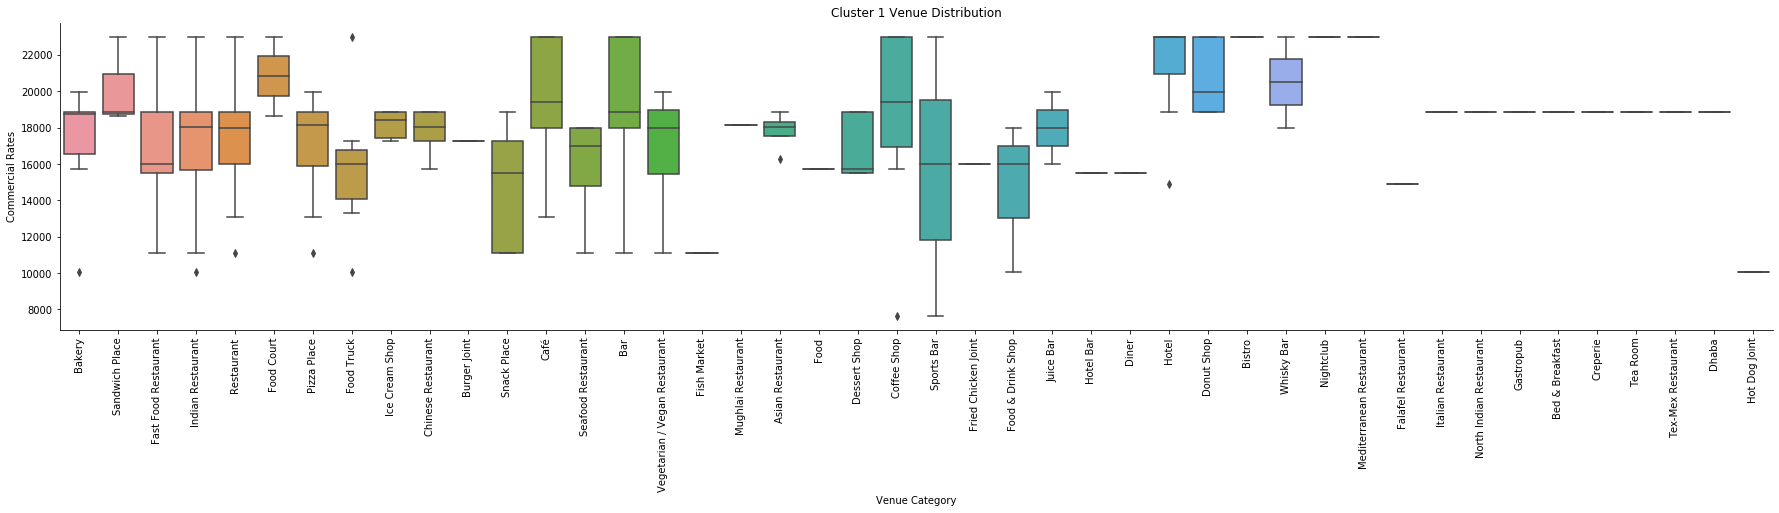

In [33]:
b1 = sns.catplot(x="Venue Category", y="Commercial Rates", kind ="box", data=mum_bai_one, height=5, aspect=5)
b1.set_xticklabels(rotation=90, fontsize=10)
plt.title("Cluster 1 Venue Distribution")
plt.show()

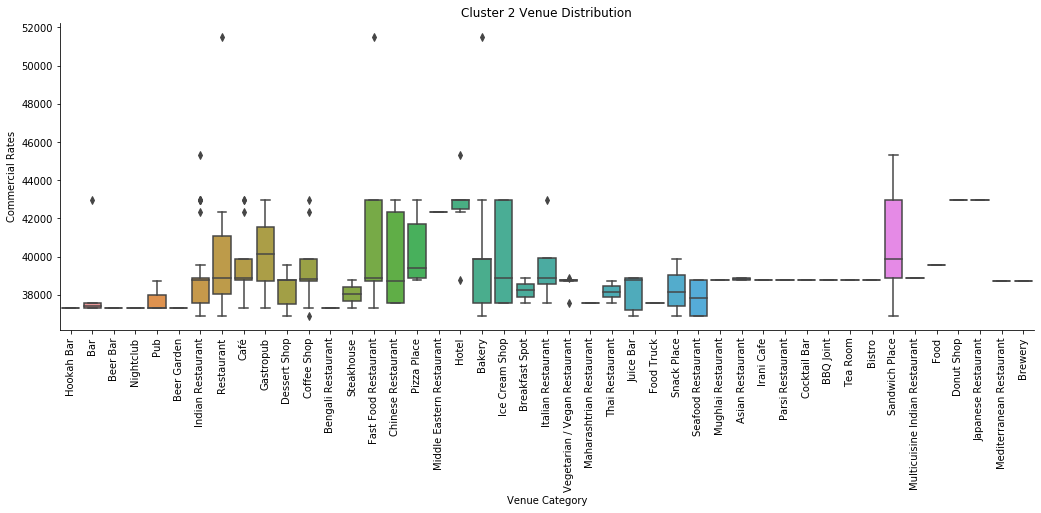

In [34]:
b2 = sns.catplot(x="Venue Category", y="Commercial Rates", kind ="box", data=mum_bai_two, height=5, aspect=3)
b2.set_xticklabels(rotation=90, fontsize=10)
plt.title("Cluster 2 Venue Distribution")
plt.show()

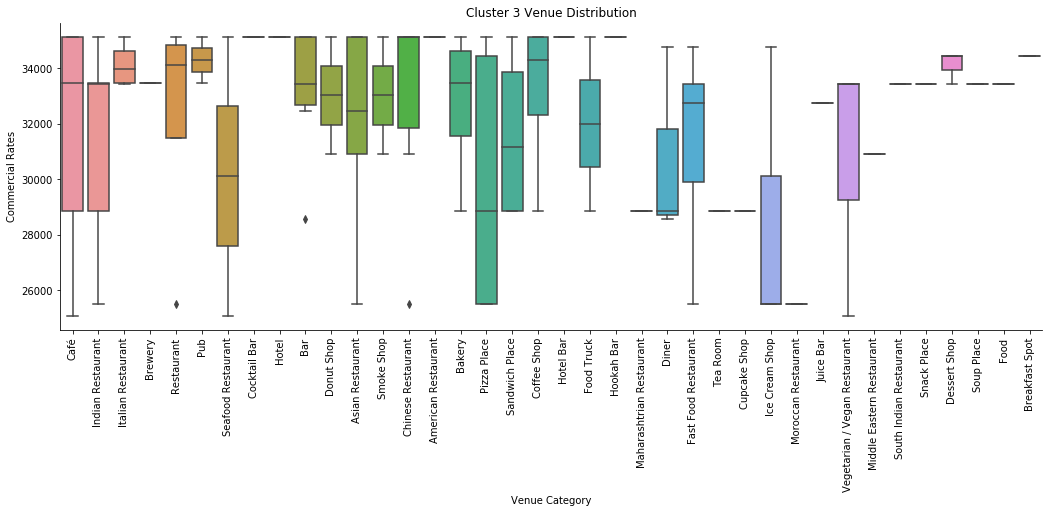

In [35]:
b3 = sns.catplot(x="Venue Category", y="Commercial Rates", kind ="box", data=mum_bai_three, height=5, aspect=3)
b3.set_xticklabels(rotation=90, fontsize=10)
plt.title("Cluster 3 Venue Distribution")
plt.show()

We can clearly see that cluster 1 has low commercial rates and a wide variety of food venues. Cluster 2 is the priciest one with numerous outliers, indicating presence of very few luxury food places. This goes hand in hand with the observation that South Mumbai (the area mainly covered by cluster 3) is a pricey business district.
Cluster 3, as discussed has a balanced representation of all kinds of food venues. It is demographically richer than cluster 1 and the commercial property rates are moderate.

### Recommendation

In [37]:
mum_bai_three["Neighborhood"].unique()

array(['Bandra', 'Juhu', 'Vile Parle', 'Mulund', 'Vidyavihar', 'Vikhroli',
       'Antop Hill', 'Byculla', 'Kamathipura', 'Matunga', 'Tardeo',
       'Mahim'], dtype=object)

A good location recommendation for Beriyan Biryani expansion is South Western Mumbai. Neighborhoods **Bandra, Juhu, Vile Parle, Vikhroli, Byculla, Matunga and Mahim** stand out. Stakeholders are advised to proceed with street level analysis of these neighborhoods for Beriyan Biryani expansion.

Some recommendations to make this analysis even more effective, by enriching the data:
1. Get User specific data from **Google Maps API about keyword - "Biryani"**. For example, how many users in a neighborhood search for Biryani, how many food places in a neighborhood have word "Biryani" in their reviews.
2. Get the online order volume data for "Biryani" from food-delivery platforms such as **Zomato and Swiggy**.

## Conclusion <a name="conclusion"></a>

This project analyzed Mumbai neighborhoods for the patterns related to food places. The purpose was to narrow down the Stakeholders' search for optimal location for company expansion to select neighborhoods. Based on the property price trends and food venue distribution across the neighborhoods, we were able to come up with important insights that helped us narrow down the options and give confident recommendations.

Stakeholders were further advised to gather more information by partnerships with appropriate entities so that this analysis can be made more effective. Also, feedback from the street level analysis of neighborhood will be very effective in refining this study to come up with better insights.